# Deep Lense Gsoc 2024

---

## Specific Task 3A: Image Super resolution

The code is written by Muhammad Mudassir Majeed

The starting date is 26th-March-2024

We will proceed in the following manner


*   Load Model Data
*   EDA on Model Data
*   Data Pre-processing
*   Model Building and Compilation (CNN Most probably)
*   Model fitting and training
*   Model Evaluation (MSE, PSNR and SSIM)


## Problem Statement

Train a deep learning-based super resolution algorithm of your choice to upscale low-resolution strong lensing images using the provided high-resolution samples as ground truths.


## Objectives

- Develop a Model for Image super Resolution.
- Train the model on lense data.
- Evaluate Model using MSE, PSNR and SSIM Metrics

## Approach

Different Approaches are available for image super resolution. Some of these include:


- CARN or CARN-M (Residual Method)
- ESRGAN (Generative Method)
- SwinIR or SwinFIR (Transformer Method) https://github.com/JingyunLiang/SwinIR
- FSRCN
- EDSR

### Model Selection

I used FSRCN model for image super resolution. The model is simple, fast and produces outstanding results. Model structure and details are shared later.

**References:**

The links shared help in understanding and implementation of Super Resolution Algorithms:

1.	https://blog.paperspace.com/image-super-resolution/
2.	https://www.v7labs.com/blog/image-super-resolution-guide
3.	https://pyimagesearch.com/2022/02/14/image-super-resolution/
4.	https://paperswithcode.com/task/image-super-resolution


---

## Imports

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, PReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.image import psnr, ssim
from tensorflow.keras.optimizers import Adam

## Sub-Programs

Here we define a list of functions and models that are used in this project

### Model Architectures

The Model used is FSRCN. Review Paper [[6]](https://www.researchgate.net/publication/372101506_Single_image_super-resolution_a_comprehensive_review_and_recent_insight) provides a comprehensive list of different models that may be used. FSRCN gives excellent results while being relatively light weight and simple.


The Model architecture is shown below:

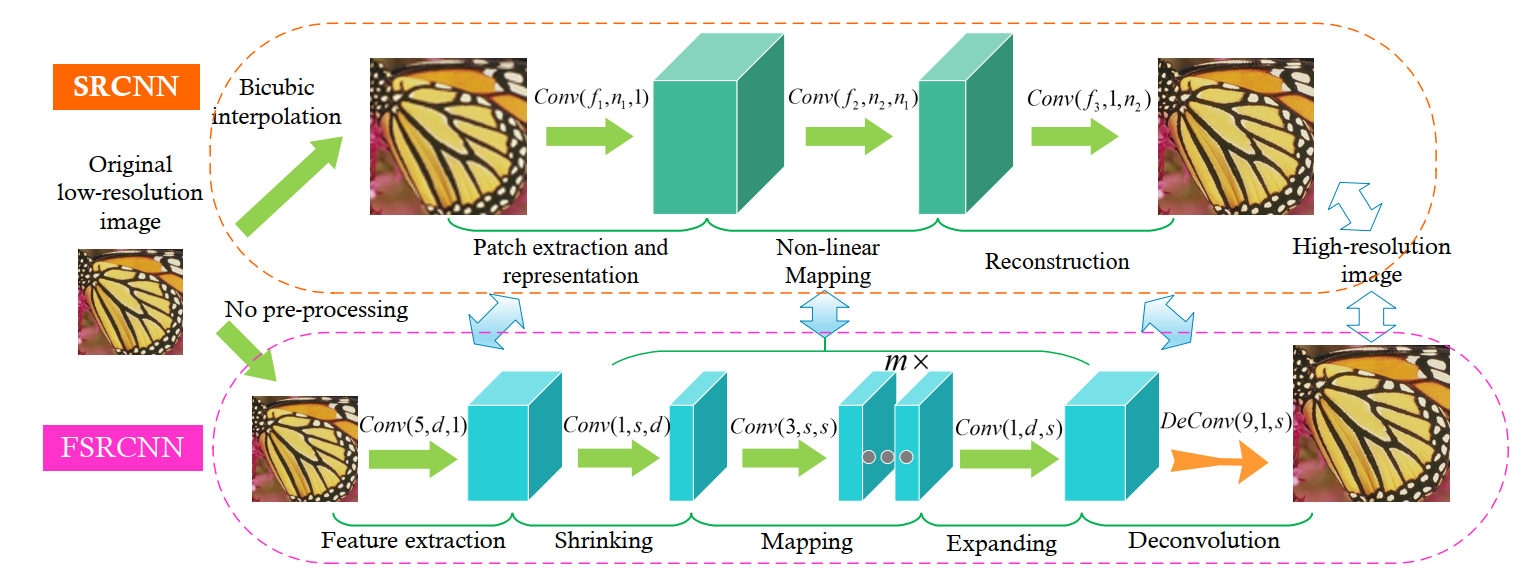

**Model Structure**

- First Part:
  - Conv(5,56,1)
- Middle Part
  - Conv(1,12,56)
  - Conv(3,12,12)*4
  - Conv(1,56,12)
- Last Part
  - DeConv(9,1,56)

The upscaling of LR to HR is governed by Deconvolution layer in the last part. Selection of filter strides in DeConv layer acts as upscaling factor. Our LR shape is (75,75,1) and HR shape is (150,150,1). So stride value is set at 2.


**References:**


1.   https://arxiv.org/abs/1608.00367
2.   https://towardsdatascience.com/learn-to-reproduce-papers-beginners-guide-2b4bff8fcca0
3.   https://towardsdatascience.com/review-fsrcnn-super-resolution-80ca2ee14da4
4.   https://www.kaggle.com/code/tyrionlannisterlzy/fsrcnn-and-espcn-way-for-super-resolution
5. https://github.com/GeorgeSeif/FSRCNN-Keras/blob/master/FSRCNN.py
6. https://www.researchgate.net/publication/372101506_Single_image_super-resolution_a_comprehensive_review_and_recent_insight

In [2]:
def model_FSRCNN(input_shape):
    model = Sequential([
        ## First Part
        # Feature Extraction
        Conv2D(filters=56, kernel_size=(5,5), padding='same', input_shape=input_shape),
        PReLU(),

        ## Mid Part
        # Shrinking
        Conv2D(filters=12, kernel_size=(1,1), padding='same'),
        PReLU(),

        # Mapping
        Conv2D(filters=12, kernel_size=(3,3), padding='same'),
        PReLU(),
        Conv2D(filters=12, kernel_size=(3,3), padding='same'),
        PReLU(),
        Conv2D(filters=12, kernel_size=(3,3), padding='same'),
        PReLU(),

        # Expanding
        Conv2D(filters=56, kernel_size=(1,1), padding='same'),
        PReLU(),

        ## Last Part
        # Deconvolution
        Conv2DTranspose(filters=1, kernel_size=(9,9), strides=(2,2), padding='same')
        # Stride = Upscaling Factor. Our HR image is 150x150. LR is 75x75. so,
        # Up scale by a factor of 2.
    ])

    return model

This function is used to load .npy image files

In [3]:
# Function to load npy images files
def load_npy_data(data_path):
    iteration_count = 0
    data_image = []

    for file_name in os.listdir(data_path):
        if file_name.endswith('.npy'):
            npy_file = os.path.join(data_path, file_name)
            image = np.load(npy_file)
            data_image.append(image)

    # We can convert our lists to numpy arrays
    data_image = np.array(data_image)
    return data_image

This function is used to plot image samples for EDA

In [4]:
def data_EDA(num_samples, data):
    fig = plt.figure(figsize=(20,5))
    for sample in range(num_samples):
        ax = fig.add_subplot(3, 12, sample + 1, xticks=[], yticks=[])
        image = np.squeeze(data[sample])
        ax.imshow(image, cmap='gray')

This function is used to plot training history

In [5]:
# Plot training history curves
def plot_history(history_object,value_1, value_2, label_1, label_2 , title):
    plt.figure(figsize=(5, 5))
    plt.plot(history_object.history[value_1], label= label_1)
    plt.plot(history_object.history[value_2], label= label_2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(title)
    plt.show()

### PSNR and SSIM as Custom Metrics
By default, tensorflow does not have psnr and ssim as metrics during training. These may be added for training by defining custom metrics during training.

Note this is not necessary. We can simply use 'mse' (Mean Squared Error)' metric during training and it will work fine. Having these extra metrics allow us to observe these metrics as well during training.

In [6]:
# Define psnr and ssim for custom metrics
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

## Program Code

### Part 1: Load Data

Data is in the form .npy files. We will iterate over each file and store data

The Original train dataset consists of 10000 images for both LR and HR images. We are only using 5000 images per class due to memory limitations. This will not affect the training of our model since dataset of 5000 images is more than sufficient for good model training

A good alternative would be to handle data more efficiently using data pipelines or generators

In [7]:
data_path_HR = "medium datasets\Dataset 3A\HR"
data_path_LR = "medium datasets\Dataset 3A\LR"

In [8]:
data_HR = load_npy_data(data_path_HR)
data_LR = load_npy_data(data_path_LR)

In [9]:
print(f'data_HR shape: {data_HR.shape}')
print(f'data_LR shape: {data_LR.shape}')

data_HR shape: (5000, 1, 150, 150)
data_LR shape: (5000, 1, 75, 75)


### Part 2: EDA on Data

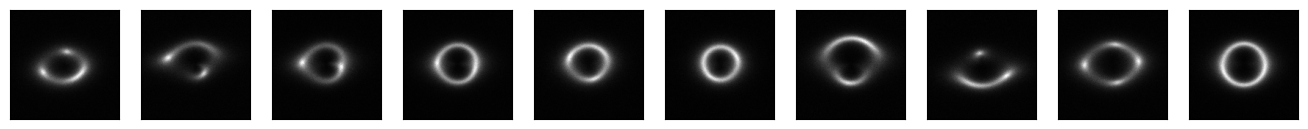

In [10]:
# For HR Data
%matplotlib inline
num_samples_to_visualize = 10
data_EDA(num_samples_to_visualize, data_HR)

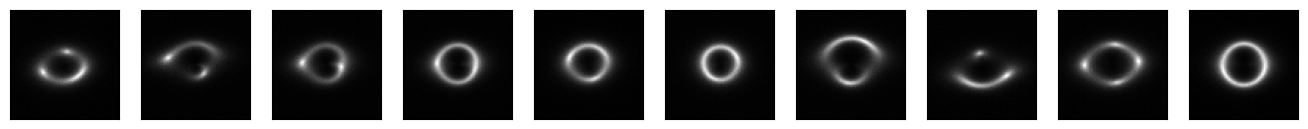

In [11]:
# For LR Data
%matplotlib inline
num_samples_to_visualize = 10
data_EDA(num_samples_to_visualize, data_LR)

### Part 3: Data pre-processing

In [12]:
data_HR = data_HR.reshape(-1, 150, 150, 1)
data_LR = data_LR.reshape(-1, 75, 75, 1)

In [13]:
print(f'data_HR shape: {data_HR.shape}')
print(f'data_LR shape: {data_LR.shape}')

data_HR shape: (5000, 150, 150, 1)
data_LR shape: (5000, 75, 75, 1)


### Part 4: Develop Model

In [14]:
input_shape = (75,75, 1)
model_FSRCNN = model_FSRCNN(input_shape)
model_FSRCNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 56)        1456      
                                                                 
 p_re_lu (PReLU)             (None, 75, 75, 56)        315000    
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 12)        684       
                                                                 
 p_re_lu_1 (PReLU)           (None, 75, 75, 12)        67500     
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 12)        1308      
                                                                 
 p_re_lu_2 (PReLU)           (None, 75, 75, 12)        67500     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 12)        

In [15]:
# Loss Function
loss_function = 'mse'

# Optimizer
optimizer = Adam(learning_rate = 0.0001)

# Metrics
# psnr and ssim are defined as custom metrics
Metrics = [MeanSquaredError(), psnr, ssim]

In [16]:
# Compile Model
model_FSRCNN.compile( optimizer = optimizer, loss = loss_function, metrics = Metrics)

### Part 5: Develop Model

In [17]:
# Train_Test Split
# X = LR , Y = HR

LR_train, LR_test, HR_train, HR_test = train_test_split(data_LR, data_HR,
                                                        test_size=0.1, random_state = 42)

In [18]:
with tf.device('/GPU:0'):
  # Model Training
  history = model_FSRCNN.fit(x= LR_train, y= HR_train, batch_size = 10,
                                  epochs = 10, shuffle = True, verbose = 2,
                                  validation_split = 0.1
                                  )

Epoch 1/10


405/405 - 184s - loss: 0.0017 - mean_squared_error: 0.0017 - psnr: 32.3088 - ssim: 0.8886 - val_loss: 1.8279e-04 - val_mean_squared_error: 1.8279e-04 - val_psnr: 37.4879 - val_ssim: 0.9609 - 184s/epoch - 454ms/step
Epoch 2/10
405/405 - 152s - loss: 1.1674e-04 - mean_squared_error: 1.1674e-04 - psnr: 39.4828 - ssim: 0.9641 - val_loss: 9.0676e-05 - val_mean_squared_error: 9.0676e-05 - val_psnr: 40.4642 - val_ssim: 0.9654 - 152s/epoch - 375ms/step
Epoch 3/10
405/405 - 148s - loss: 8.6479e-05 - mean_squared_error: 8.6479e-05 - psnr: 40.6709 - ssim: 0.9658 - val_loss: 8.1541e-05 - val_mean_squared_error: 8.1541e-05 - val_psnr: 40.9178 - val_ssim: 0.9660 - 148s/epoch - 364ms/step
Epoch 4/10
405/405 - 147s - loss: 8.0832e-05 - mean_squared_error: 8.0832e-05 - psnr: 40.9590 - ssim: 0.9664 - val_loss: 7.8552e-05 - val_mean_squared_error: 7.8552e-05 - val_psnr: 41.0787 - val_ssim: 0.9665 - 147s/epoch - 364ms/step
Epoch 5/10
405/405 - 152s - loss: 7.8455e-05 - mean_squared_error: 7.8

Observe Training history

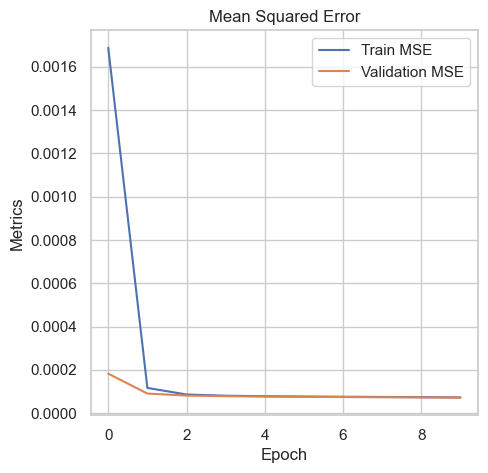

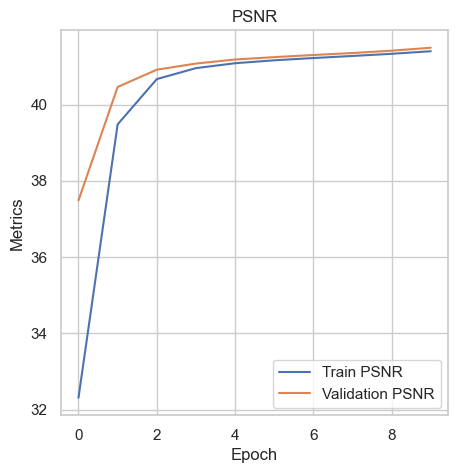

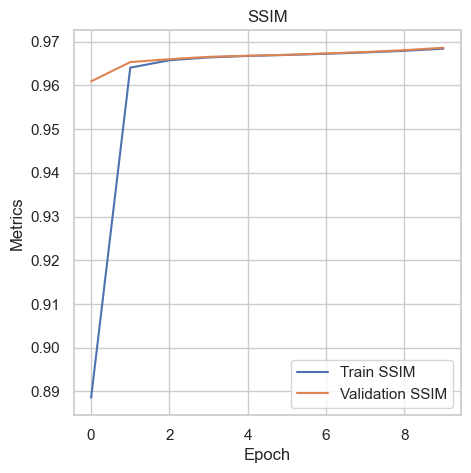

In [19]:
# Loss Curves for train and valid data for observing overfitting.
# Plotting the learning curves for train and validation metrics

# Set seaborn style
sns.set(style="whitegrid")

# Plotting MSE
plot_history(history,'mean_squared_error', 'val_mean_squared_error', 'Train MSE','Validation MSE', 'Mean Squared Error')

# Plotting PSNR
plot_history(history,'psnr', 'val_psnr', 'Train PSNR','Validation PSNR', 'PSNR')

# Plotting SSIM
plot_history(history,'ssim', 'val_ssim', 'Train SSIM','Validation SSIM', 'SSIM')

### Part 6: Evaluate Model

In [20]:
model_FSRCNN.metrics_names

['loss', 'mean_squared_error', 'psnr', 'ssim']

In [21]:
train_loss, train_MSE, train_psnr, train_ssim = model_FSRCNN.evaluate(LR_train, HR_train)
test_loss, test_MSE, test_psnr, test_ssim = model_FSRCNN.evaluate(LR_test, HR_test)

print('--'*30)
print(f'Model Training MSE: {train_MSE:.5f}')
print(f'Model Training PSNR: {train_psnr:.5f}')
print(f'Model Training SSIM: {train_ssim:.5f}')
print('--'*30)
print(f'Model Testing MSE: {test_MSE:.5f}')
print(f'Model Testing PSNR: {test_psnr:.5f}')
print(f'Model Testing SSIM: {test_ssim:.5f}')

16/16 [==============================] - 8s 487ms/step - loss: 7.2387e-05 - mean_squared_error: 7.2387e-05 - psnr: 41.4337 - ssim: 0.9684
------------------------------------------------------------
Model Training MSE: 0.00007
Model Training PSNR: 41.45075
Model Training SSIM: 0.96871
------------------------------------------------------------
Model Testing MSE: 0.00007
Model Testing PSNR: 41.43373
Model Testing SSIM: 0.96837


### Part 7: Save Model

In [22]:
model_FSRCNN.save('Trained Models\Task_3A_FSRCNN.keras')

**Note: Please pre-process test data as mentioned, before testing it using saved model**

processed_HR_data = loaded_HR_data.reshape(-1, 150, 150, 1)
processed_LR_data = loaded_LR_data.reshape(-1, 75, 75, 1)

First Load HR data and LR data. loaded_HR_data is HR data. loaded_LR_data is LR Data. Pre-process to change shape as mentioned then use.

---

## Discussion

The task of super image resolution was performed. FSRCN model architecture was used. The results are very good. PSNR values above 40 and SSIM values above 0.95 are achieved.

## Future Work

The results are very good. However, different improvements can be made. Different models may be tried, tested and compared. The latest state of the art in image super resolution is SWIN-FIR structure. This method could be explored to further enhance super resolution capabilities for DEEP LENSE project.

**Reference:** https://paperswithcode.com/task/image-super-resolution

## Conclusion

The model is a decent effort for solving the image super resolution problem. The results may be further expanded by exploring other models and comparison. 

---